### Task 10: Add Constant Product Trading interest rate as continuous rebase
* https://cryptorating.eu/whitepapers/Aave/aave-v2-whitepaper.pdf

In [1]:
import os
import copy
import numpy as np
import time
import matplotlib.pyplot as plt
cwd =  os.getcwd().replace("notebooks/test","")
os.chdir(cwd)

In [2]:
t0 = time.time()

In [3]:
from python.dev.token import Token

import time
from datetime import datetime

timestamp1 = int(time.time()) 
dt_object1 = datetime.fromtimestamp(timestamp1)

timestamp2 = timestamp1 + 10
dt_object2 = datetime.fromtimestamp(timestamp2)

print("dt_object =", dt_object1)
print("dt_object =", dt_object2)

dt_object = 2022-04-15 09:32:13
dt_object = 2022-04-15 09:32:23


In [4]:
from abc import *
from datetime import datetime

class Event(ABC):
    
    EVENT_DEPOSIT = 'DEPOSIT'
    EVENT_WITHDRAW = 'WITHDRAW'
    EVENT_TRADE = 'TRADE'
    
    @abstractmethod
    def get_time_delta(self):
        pass
    @abstractmethod
    def type_of(self):
        pass
    @abstractmethod
    def get_apy(self):
        pass
    @abstractmethod
    def get_delta(self):
        pass     
     
class Deposit(Event):
    
    def __init__(self, apy, delta, t_delta):
        self.__t_delta = t_delta
        self.__delta = delta
        self.__apy = apy
        
    def get_time_delta(self):
        return self.__t_delta
       
    def get_delta(self):
        return self.__delta
    
    def get_apy(self):
        return self.__apy
    
    def type_of(self):
        return Event.EVENT_DEPOSIT
    
class Withdraw(Event):
    
    def __init__(self, apy, delta, t_delta):
        self.__t_delta = t_delta
        self.__delta = -delta
        self.__apy = apy
        
    def get_time_delta(self):
        return self.__t_delta  
    
    def get_delta(self):
        return self.__delta
    
    def get_apy(self):
        return self.__apy    
    
    def type_of(self):
        return Event.EVENT_WITHDRAW    

In [5]:
class Record():
    def __init__(self, event):
        self.__event = event
        self.__balance = 0
        self.__principle = 0
        self.__yield = 0
    
    def get_balance(self):
        return self.__balance
    
    def get_principle(self):
        return self.__principle    
    
    def get_yield(self):
        return self.__yield   
    
    def get_event(self):
        return self.__event       
    
    def update_event(self, event):
        self.update_balance()  
        self.update_principle()
        self.__event = copy.copy(event) 
   
    def update_principle(self):
        self.__principle = self.__principle + self.__event.get_delta()

    def update_balance(self):
        self.update_yield()
        self.__balance = self.__balance + self.__yield + self.__event.get_delta()  
       
    def update_yield(self):
        t_delta = self.__event.get_time_delta()
        apy = self.__event.get_apy()
        self.__yield = Yield(self.__balance, t_delta, apy).apply()
        

In [6]:
class Archive():
    
    def __init__(self, records = None):
        self.__records = [] if records == None else records
        
    def get_records(self):
        return self.__records 
    
    def get_num_records(self):
        return len(self.__records)   
    
    def get_record(self, index):
        return self.__records[index]  
    
    def add_record(self, record):
        return self.__records.append(copy.copy(record))    
    

class EventArchive(Archive):   
    def __init__(self, t0, records = None):
        super().__init__(records)
        self.__t0 = t0
    
    def get_principle(self):
        N = super().get_num_records()
        records = super().get_records()
        return [records[k].get_principle() for k in range(N)]
    
    def get_balance(self):
        N = super().get_num_records()
        records = super().get_records()
        return [records[k].get_balance() for k in range(N)]

    def get_tstamp(self):
        N = super().get_num_records()
        ustamp = self.get_ustamp()
        return [datetime.fromtimestamp(t) for t in ustamp]
    
    def get_ustamp(self):
        N = super().get_num_records()
        records = super().get_records()  
        ustamp = [self.__t0]
        for k in range(N): 
            ustamp.append(ustamp[-1]+records[k].get_event().get_time_delta())
        return ustamp[1:]
        
    

In [7]:
def compound_return(rebase, freq=12, deposit=1):
    return deposit*(1+rebase/100)**(freq)

def unit_return(A0, apy, t, freq = 12):
    multiplier = 1 + apy/100
    return A0*(multiplier)**(t/freq)

def time_units_between(a0,a1,rebase):
    return np.log(a1/a0)/np.log(1+rebase/100)

In [8]:
class AToken(Token):
    
    def __init__(self, name):
        super().__init__(name, None, None)
        
    def burn(user_address, receiver_address, delta, index):
        return None
    
    def mint(user_address, delta, index):
        return None  
    
    def mint_to_treasury(delta, index):
        return None  
    
    def transfer_on_liquidation(from_address, to_address, delta):
        return None   
       
    def handle_repayment(receiver_address, delta):    
        return None        

In [9]:
def unit_return(A0, apy, t, freq = 12):
    multiplier = 1 + apy/100
    return A0*(multiplier)**(t/freq)

In [10]:
DAYS_IN_YEAR = 365.25
HOURS_IN_DAY = 24
SECONDS_IN_HOUR = 3600

class Yield():
    def __init__(self, balance, delta_t, apy):
        self.__balance = balance
        self.__delta_t = delta_t
        self.__apy = apy
             
    def __seconds_per_year(self):
        return DAYS_IN_YEAR*HOURS_IN_DAY*SECONDS_IN_HOUR

    def apply(self):  
        multiplier = 1 + self.__apy
        freq = self.__seconds_per_year()
        new_balance = self.__balance*(multiplier)**(self.__delta_t/freq)
        return new_balance-self.__balance
    

In [11]:
APY = 0.1
rec = Record(Deposit(0,0,0))
events = EventArchive(t0)

for k in range(320):
    delta = np.random.gamma(1, 10)   
    select = np.random.choice(2, 1, p=[0.70, 0.30])[0]
    t_delta = np.random.negative_binomial(1, 0.00001)
      
    if(select == 0): 
        event = Deposit(APY,delta,t_delta)
    else:
        event = Withdraw(APY,delta,t_delta)  

    rec.update_event(event)

    events.add_record(rec)

principle = events.get_principle() 
balance = events.get_balance() 
tSamp = events.get_tstamp()

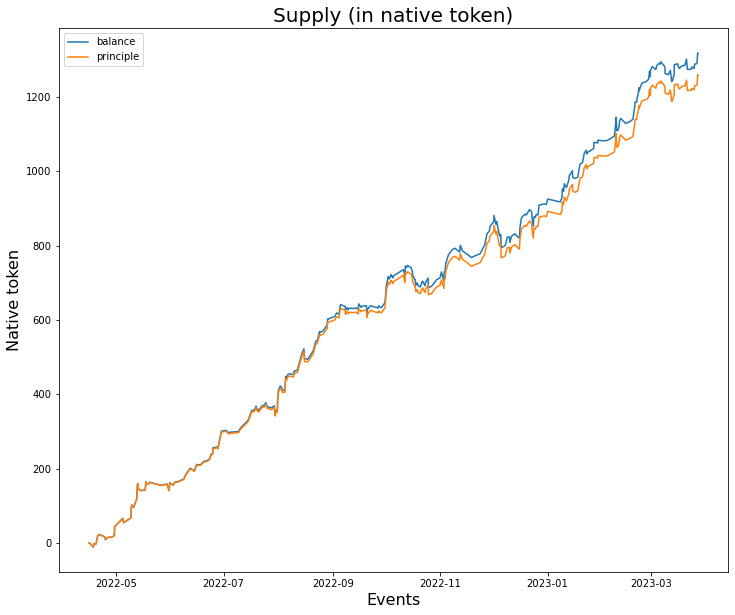

In [12]:
import matplotlib.pyplot as plt

fig, (balance_ax) = plt.subplots(nrows=1, sharex=True, sharey=False, figsize=(12, 10))

balance_ax.plot(tSamp, balance, label='balance') 
balance_ax.plot(tSamp, principle, label='principle') 

balance_ax.set_title("Supply (in native token)", fontsize=20)
balance_ax.set_ylabel("Native token", fontsize=16)
balance_ax.set_xlabel('Events', fontsize=16)
balance_ax.legend()

In [13]:
balance = [0]
principle = [0]
yields = [0]
uSamp = [t0]
APY = 0.1
events = [Deposit(0,0,0)]

for event in range(300):
    delta = np.random.gamma(1, 10)   
    select = np.random.choice(2, 1, p=[0.65, 0.35])[0]

    t_delta = np.random.negative_binomial(1, 0.00001)
    #prev_balance = events[-1].current_balance()    
    
    if(select == 0): 
        event = Deposit(APY,delta,t_delta)
    else:
        event = Withdraw(APY,delta,t_delta)  
        delta = -delta

    events.append(event)
    
    yield_prev_delta = Yield(balance[-1], t_delta, APY).apply()
    new_balance = yield_prev_delta + delta
    
    principle.append(principle[-1]+delta)
    balance.append(balance[-1]+new_balance)
    yields.append(yields[-1]+yield_prev_delta)
    uSamp.append(uSamp[-1]+t_delta)
    
tSamp = [datetime.fromtimestamp(t) for t in uSamp] 
#apy_balance = [x + y for (x, y) in zip(balance, yield_balance)] 

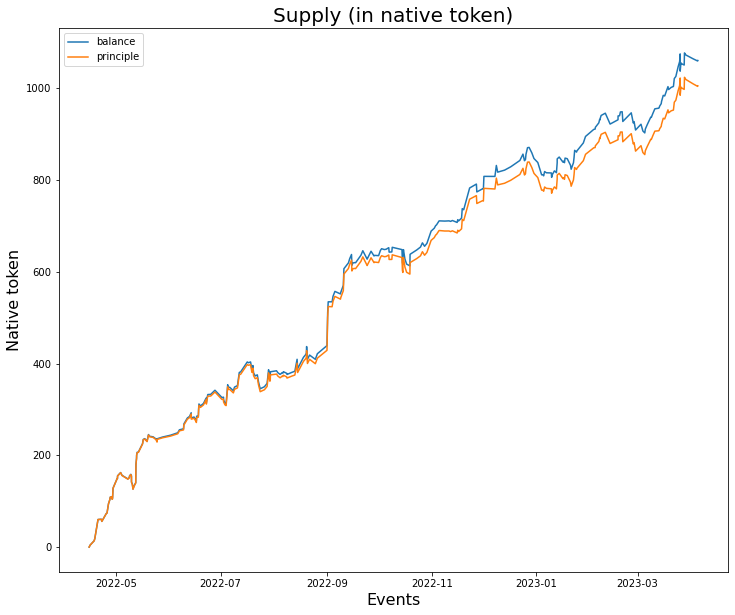

In [14]:
import matplotlib.pyplot as plt

fig, (balance_ax) = plt.subplots(nrows=1, sharex=True, sharey=False, figsize=(12, 10))
balance_ax.plot(tSamp, balance, label='balance') 
balance_ax.plot(tSamp, principle, label='principle') 
balance_ax.set_title("Supply (in native token)", fontsize=20)
balance_ax.set_ylabel("Native token", fontsize=16)
balance_ax.set_xlabel('Events', fontsize=16)
balance_ax.legend()
